## R4ML: Classification Model using SVM

#####    [Alok Singh](https://github.com/aloknsingh/)

### Contents

#### &nbsp;&nbsp;  1. Introduction
#### &nbsp;&nbsp;  2. Problem Statement (Predict whether airline will be Delayed)
#### &nbsp;&nbsp;  3. Extra Data Preparation
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  3.1. Normalization
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  3.2. One Hot Encoding (DummyCoding)
#### &nbsp;&nbsp;  4. Classification using SVM (Support Vector Machine)
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  4.1. SVM Overview?
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  4.2. Train SVM model using R4ML.
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  4.3. Scoring of SVM model on held out data using R4ML.
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  4.4. Summary of classification using SVM.
##### &nbsp;&nbsp;  5. Model-Tuning via Cross-Validation
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  5.1. Cross Validation (CV) overview.
##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  5.2. CV for SVM model.
##### &nbsp;&nbsp;  6. Summary and next steps ...

## 1. Introduction

 In this section, we will walk through the general concept of model training and then use the R4ML to conduct Support Vector Machine (SVM) classification. We will then train and score the data and conduct cross validation in order to select the best set of hyper-parameters.
 
 In our introductory Code Pattern [R4ML on Watson Studio](https://github.com/IBM/r4ml-on-watson-studio), we discussed how to load R4ML and do some preprocessing with the data. We will repeat those steps here. Here are the links to those notebooks, which provide more details on each of these steps:
 
 * [R4ML BigData Exploration Introduction](https://github.com/IBM/r4ml-on-watson-studio/blob/master/notebooks/R4ML_Introduction_Exploratory_DataAnalysis.ipynb)
 * [R4ML Data Preparation and Dimension Reduction](https://github.com/IBM/r4ml-on-watson-studio/blob/master/notebooks/R4ML_Data_Preprocessing_and_Dimension_Reduction.ipynb)
 
 

In [ ]:
# first step would be to install the R4ML in your environment
# install dependencies . This steps only need to be done once
install.packages(c("uuid", "R6", "PerformanceAnalytics"), repos = "http://cloud.r-project.org")
install.packages(c("cowplot"), repos = "http://cloud.r-project.org")

library("SparkR")

download.file("http://codait-r4ml.s3-api.us-geo.objectstorage.softlayer.net/R4ML_0.8.0.tar.gz", "~/R4ML_0.8.0.tar.gz")

install.packages("~/R4ML_0.8.0.tar.gz", repos = NULL, type = "source")

In [1]:
library(R4ML)
library(SparkR)

# init the session.
r4ml.session()

# read the airline dataset.
airt <- airline

# For this demo we will use the small data to illustrate the theme. User are encouraged to try bigger dataset
# by downloading it

airt <- airt[airt$Year >= "2007",]

air_hf <- as.r4ml.frame(airt)

airs <- r4ml.sample(air_hf, 0.1)[[1]]


# list of all the columns in the dataset.
total_feat <- c(
  "Year", "Month", "DayofMonth", "DayOfWeek", "DepTime","CRSDepTime","ArrTime",
  "CRSArrTime", "UniqueCarrier", "FlightNum", "TailNum", "ActualElapsedTime",
  "CRSElapsedTime", "AirTime", "ArrDelay", "DepDelay", "Origin", "Dest",
  "Distance", "TaxiIn", "TaxiOut", "Cancelled", "CancellationCode",
  "Diverted", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay",
  "LateAircraftDelay")

#"Year", "Month", "DayofMonth", "DayOfWeek",
#categorical features of interest.
cat_feat <- c("UniqueCarrier", "FlightNum", "TailNum", "Origin", "Dest",
  "CancellationCode", "Diverted")

numeric_feat <- setdiff(total_feat, cat_feat)

# these features have no predictive power as it is uniformly distributed i.e less information.
unif_feat <- c("Year", "Month", "DayofMonth", "DayOfWeek")

# these features are co-related with the ArrDelay which we will use and hence we will ignore these.
const_feat <- c("WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay")

col2rm <- c(unif_feat, const_feat, cat_feat)

rairs <- SparkR::as.data.frame(airs)
airs_names <- names(rairs)
rairs2_names <- setdiff(airs_names, col2rm) 
rairs2 <- rairs[, rairs2_names]

# first we will create the imputation maps i.e what to do with each column in the pre-processing steps
# We will replace numeric feature with mean and categorical feature with constant "CAT_NA"

airs_ia <- total_feat

# mapping from column(feature) to imputation method.
airs_im <- lapply(total_feat,
               function(feat) {
                 v= if (feat %in% numeric_feat) {"global_mean"} else {"constant"}
                 v
               })
# convert the list into vector (key, value)
airs_im <- sapply(airs_im, function(e) {e})


# set imputation values of "CAT_NA" for categorical features
airs_iv <- setNames(as.list(rep("CAT_NA", length(cat_feat))), cat_feat)
na.cols<- setdiff(total_feat, airs_ia)

# we cache the output so that not to re-exe Spark executation DAG.
# note usually caching a good idea before doing a signicant (in terms of time) operations.
dummy <- cache(airs)

# Run the actual, pre-processing to clean the data.
airs_t_res <- r4ml.ml.preprocess(
    airs,
    dummycodeAttrs = c(),
    binningAttrs = c(), numBins=4,
    missingAttrs = airs_ia,
    imputationMethod = airs_im,
    imputationValues = airs_iv,
    omit.na=na.cols, # we remove all the na, 
    recodeAttrs=cat_feat # recode all the categorical features
)


# the transformed data frame
airs_t <- airs_t_res$data
# the relevant metadata list
airs_t_mdb <- airs_t_res$metadata

# cache the transformed data
dummy <- cache(airs_t)
## showDF(airs_t, n = 2)

Warning message:
“WARN[R4ML]: Reloading SparkR”Loading required namespace: SparkR

  _______   _    _    ____    ____  _____
 |_   __ \ | |  | |  |_   \  /   _||_   _|    
   | |__) || |__| |_   |   \/   |    | |      
   |  __ / |____   _|  | |\  /| |    | |   _  
  _| |  \ \_   _| |_  _| |_\/_| |_  _| |__/ | 
 |____| |___| |_____||_____||_____||________| 
 

[R4ML]: version 0.8.1
Warning message:
“no function found corresponding to methods exports from ‘R4ML’ for: ‘collect’”
Attaching package: ‘SparkR’

The following object is masked from ‘package:R4ML’:

    predict

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union

Warning message:
“WARN[R4ML]:  driver.memory not defined. Defaulting to 2G”Spark package found in SPARK_HOME: /usr/

Launching java with spark-submit command /usr/local/src/spark21master/spark/bin/spark-submit --jars /gpfs/global_fs01/sym_shared/YPProdSpark/user/sa28-9716de71e3ac0f-9ac12ed2939a/R/libs/R4ML/java/SystemML.jar  --driver-memory "2G" sparkr-shell /gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/notebook/tmp/Rtmp3crbrS/backend_port15425b847e9e 


[R4ML]: Default log level will be set to 'INFO'
[R4ML]: To change call r4ml.setLogLevel(NewLevel)
INFO[calc num partitions]: 48 partitions
INFO[as.r4ml.frame]: repartitioning an object of size: 2448976 into 48 partitions
INFO[r4ml.ml.preprocess]: running proxy.omit.na
INFO[r4ml.ml.preprocess]: running proxy.impute
INFO[r4ml.ml.preprocess]: running proxy.normalize
INFO[r4ml.ml.preprocess]: running proxy.binning
INFO[r4ml.ml.preprocess]: running proxy.recode
INFO[r4ml.ml.preprocess]: running proxy.onehot


## 2. Problem Statement (Predict whether Airline will be Delayed)

Many real world problems involve analyzing data and predicting certain outcomes. Basic statistics can help with some of the insights, but to go deeper into predictive analytics, we need stronger and more complex mathematical models. For this, there are various kinds of machine learning models that are used. R4ML, for example, has a built-in collection of many ML models. Other packages also offer ML models, but problems often arise when the data becomes huge and requires scalable machine learning models. R4ML is able to fill this gap.

To better understand this R4ML process, we will begin by trying out an example prediction problem.

As mentioned, the airline dataset is used for the analysis of airline delays. We will do the same. It provides an "ArrDelay" value which provides delay information about past flights. But, what about future flights? How could we use the data to determine if a flight is going to be delayed or not?

We will use the linear SVM classifier, where the predictors would be ("DepTime", "ArrTime", "ActualElapsedTime", "AirTime", "ArrDelay", "DepDelay", "Distance")

## 3. Extra Data Preparation

We saw a few data preparation points in our previous notebook [R4ML Data Preparation and Dimension Reduction](https://github.com/IBM/r4ml-on-watson-studio/blob/master/notebooks/R4ML_Data_Preprocessing_and_Dimension_Reduction.ipynb). We will now perform two extra pre-processing steps to increase the predictive power of the features.


### 3.1. Normalization

First let's normalize the scale variable to handle the case where one variable may have a much larger scale than another. For example, the scale could be inconsistently measured if we were to mix seconds and hours. In R4ML, normalization involves making the values betwen 0 and 1. This is done by first shifting the values by mean, and then deviding it by a standard deviation.

For the classifier, without normalization, it will assume that both variables are on the same scale which will produce an erroneous result.


In [2]:
# list of the normalized columns
col2norm <- setdiff(names(airs_t), cat_feat)

# print the columns they we are normalizing
cat("\n\n Columns that are normalized\n")
col2norm

# lets check out the values before normalization
cat("\n\n Before Normalization: a few samples of data\n")

showDF(select(airs_t, c("Distance", "AirTime")), n=2)

airs_t_norm_info <- do.call("r4ml.normalize", unlist(list(airs_t, col2norm))) # extract the r4ml frame from the output
airs_t_norm <- airs_t_norm_info$data

# we can see the values after normalization outputs
cat("\n\n After Normalization: a few samples of data\n")
showDF(select(airs_t_norm, c("Distance", "AirTime")), n=2)



 Columns that are normalized


[1] "Year"              "Month"             "DayofMonth"       
 [4] "DayOfWeek"         "DepTime"           "CRSDepTime"       
 [7] "ArrTime"           "CRSArrTime"        "ActualElapsedTime"
[10] "CRSElapsedTime"    "AirTime"           "ArrDelay"         
[13] "DepDelay"          "Distance"          "TaxiIn"           
[16] "TaxiOut"           "Cancelled"         "CarrierDelay"     
[19] "WeatherDelay"      "NASDelay"          "SecurityDelay"    
[22] "LateAircraftDelay"



 Before Normalization: a few samples of data
+--------+-------+
|Distance|AirTime|
+--------+-------+
|    1589|    171|
|     391|     61|
+--------+-------+
only showing top 2 rows


 After Normalization: a few samples of data
+--------------------+-------------------+
|            Distance|            AirTime|
+--------------------+-------------------+
|   0.719871967110263| 0.4694670286460591|
|-0.30149714249653214|-0.3184303978500804|
+--------------------+-------------------+
only showing top 2 rows


As you can see in the output (which only prints two columns) , the value has been normalized.

### 3.2. One Hot Encoding (DummyCoding)

Next, we will do encoding of the categorical variable of interest.

**Why do this encoding?**

There are two types of categorical variables: ordinal and nominal. Ordinal variables are like binned-continuous variables. Examples include the size of t-shirts, blood pressure ranges and more. Nominal variables are more exact, such as USA states, airline carriers, airports, etc. By conducting encoding, we will map the above to (1,0), (0,1) and by adding extra features, we will convert categorical, nominal variables into something that can be used by the ML algorithm for classification.

The reason we would like to do this encoding is as follows.

Lets assume we didn't do the One Hot encoding for a categorical feature (e.g Destination). If we just did typical encoding (e.g. label encoding where values are converted to numbers), the various destinations will be mapped to numbers (e.g. SFO->12, LAX->0, etc). This doesn't work well because we are arbitrarily giving SFO a higher number or higher weightage than LAX. If we do One Hot encoding, we are making sure we give equal weightage to all non-ordered features.

In [3]:
airs_t_norm_m <- as.r4ml.matrix(airs_t_norm) #these are columns which will be our predictors
oh_cols <- c("Origin", "Dest") # get the one hot encoded matrix
cat(paste0("Running one hot encoding for 'Origin' and 'Dest' columns\n"))
airs_t_oh_info <- suppressWarnings(r4ml.onehot(airs_t_norm_m, oh_cols)) # this contains the one hot encoded r4ml matrix
airs_t_oh <- airs_t_oh_info$data
#this contains the environment which contains the mapping from #original colum to one hot encoded col
airs_t_oh_env <- airs_t_oh_info$metadata
# get the list of new columns which we will use later
oh_exp_cols <- unlist(lapply(oh_cols, function(col) {get(col, envir=airs_t_oh_env)}))

Running one hot encoding for 'Origin' and 'Dest' columns


##### Convert AirDelay to Categorical Variable.

In order to illustrate the classification process, we will now convert our independent variable (i.e **Y == ArrDelay**) into a categorical variable.



In [9]:
svm_pred_y <- "Delayed"
airs_t_delayed <- SparkR::mutate( 
    airs_t_oh,
    Delayed = ifelse(airs_t_oh$ArrDelay > 0, 2, 1) # they must be in recoded so we use 1 2
)

## 4. Classification using SVM (Support Vector Machine)

As we have learned, R4ML provides a library with built-in, scalable ML algorithms. But which algorithm should you use? You have the choice of a Support Vector Machine (SVM) or Mlogit (Multiclass logistic regression).

For this example, we will use SVM. For our initial approach, we will simply use the pre-canned SVM algorithm provided by R4ML. But first, that lets talk a little about SVM.



### 4.1. SVM Overview

##### SVM Intuition
SVM is a supervised classification technique that is listed under supervised learning models. In simple terms, it involves finding the [hyperplane](https://en.wikipedia.org/wiki/Hyperplane) (line in 2D, plane in 3D and hyperplane in higher dimensions) that best separates two classes of points with the maximum margin (see the picture below).

More SVM details are avaiable [here](https://en.wikipedia.org/wiki/Support_vector_machine).



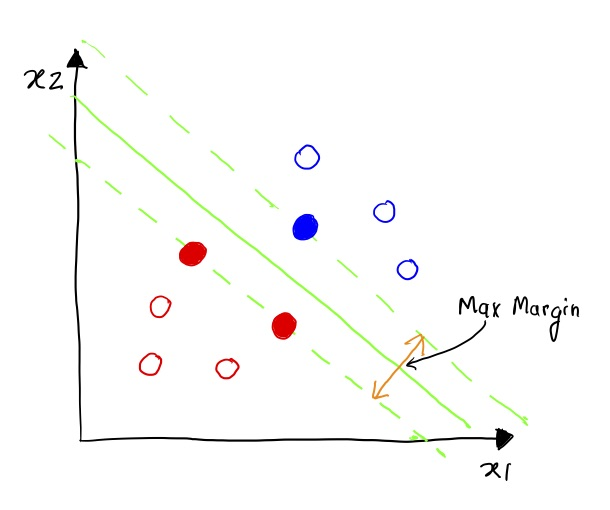

##### Why should SVM be preferred?

First we note that both Logistic regression and SVM can form non-linear decision surfaces and can be coupled with a kernel trick. If Logistic regression can be coupled with the kernel then why to use SVM? Compared to logistic regression, the SVM algorithm has basic advantages in terms of complexity. 

* SVM is found to have better practical performance, in most cases.
* SVM is computationally cheaper O(N^2*K) where K is the number of support vectors (support vectors are those points that lie on the class margin), where as logistic regression is O(N^3).
* The SVM classifier depends only on a subset of points. Since we need to maximize the distance between the closest points of two classes (aka margin), we need to focus only on a subset of points. This is not the case for logistic regression.

### 4.2.  Train SVM model using R4ML


In the typical machine learning modelling process, you usually divide the data set into training and test data (i.e. hold out) set. Then you train your model on the first data set and see it's accuracy on the latter. We will see the more detailed cross validation steps later, but for now, let's follow the simpler steps where we train the model and score it.

##### Split the data set into two

In [10]:
## set up the predictors
svm_scale_predictors_1 <- c("DepTime", "ArrTime", "ActualElapsedTime", "AirTime", "ArrDelay", "DepDelay", "Distance")
svm_nom_predictors_1 <- oh_exp_cols
svm_predictors_1 <- c(svm_scale_predictors_1, svm_nom_predictors_1)

In [11]:
# split the data set into two training and test

svm_inputcols_1 <- c(svm_predictors_1, svm_pred_y)
svm_inputs_df_1 <- select(airs_t_delayed, svm_inputcols_1)

svm_inputs_hm_1 <- as.r4ml.matrix(svm_inputs_df_1)

cat("Spliting dataset into train and test\n")
svm_random_split_1 <- r4ml.sample(svm_inputs_hm_1, c(0.7, 0.3))


svm_train_1 <- svm_random_split_1[[1]]
svm_test_1 <- svm_random_split_1[[2]]



Spliting dataset into train and test


In [14]:
## for R4ML to work properly we have to encode the data type for columns to be one of scale or nominal. Lets change those
# lets create a function to be used in future.
ml.assign.coltypes <- function(hm, pred_y_cols) {
  dt <- SparkR::dtypes(hm)
  nn <- SparkR::colnames(hm)
  dd <- sapply(dt, function(e) {e[[2]]}) # remove
  lookup <- c(int = "scale", double = "scale", string = "string")
  mlt <- unname(lookup[dd])
  mlt[match(pred_y_cols, nn)]<-"nominal"
  ml.coltypes(hm) <- mlt
  hm
}

#apply it to the svm dataset
svm_train_1 <- ml.assign.coltypes(svm_train_1, svm_pred_y)


In [15]:
# cache the train and test dataset for better performance
dummy <- cache(svm_train_1)
dummy <- cache(svm_test_1)

##### R4ML SVM model training

The next step is to train the scalable machine learning model as follows:


In [16]:
cat("Creating SVM model \n")
svm_model_1 <- suppressWarnings(r4ml.svm(Delayed ~ ., data = svm_train_1))


# we can see the weights of some of the
cat(" SVM model's coefficients\n")
head(collect(svm_model_1@dmlOuts[[ 'weights' ]]))

Creating SVM model 
 SVM model's coefficients


weights,weights
-0.2173001,0.2173001
0.1102485,-0.1102485
-0.6968500,0.6968500
0.3014660,-0.3014660
-5.7695097,5.7695097
-1.1122362,1.1122362


**NOTE**: The two columns correspond to the cases for output. For example, if Delayed == 1, the flight is delayed, and if Delayed == 2, the flight is not delayed. Each column represents the co-efficient for the corresponding SVM model. More details are avaiable at [SystemML SVM](http://apache.github.io/systemml/algorithms-classification.html#support-vector-machines)

### 4.3.  Scoring of SVM model on held out data using R4ML

Let's score the SVM model on the held-out data. After we have created a predicted set we would like to measure it's performance in terms of accuracy. Accuracy is the ratio of correctly predicted samples to the total samples.

Let's check out the accuracy on the hold-out data.


In [17]:
cat(" SVM model's scoring\n")
svm_preds_1 <- suppressWarnings(predict(svm_model_1, svm_test_1))
svm_preds_1$accuracy

 SVM model's scoring


INFO[predict.r4ml.svm]: Predicting labels using given SVM model/gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/R4ML/scratch_workspace/r4ml.svm/e1ab9a2b-afb9-459a-a08e-b8ab87a95f02/on data
INFO[r4ml.ml.checkModelFeaturesMatchData]: Ensuring the consistency between model and data features
INFO[packagePredictSvmOutput]: Packaging output of svm predict


[1] 92.7907

##### Analysing the prediction

As we know, accuracy in classification models can be misleading. Hence apart from accuracy, prediction also contains the actual confusion 
matrix and predicted scores.

A [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is just the snapshot picture of the real performance of the classification model, as shown in the following picture:


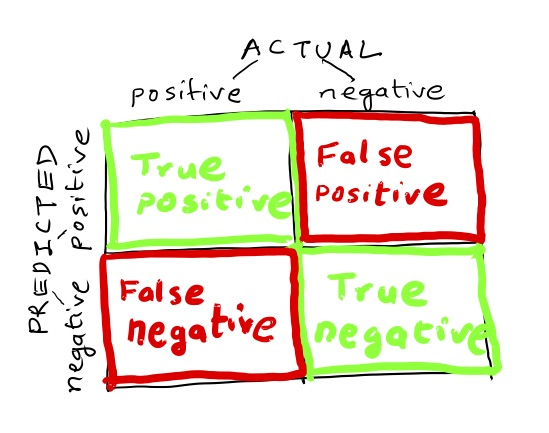

##### Plotting the confusion matrix

Let's see how a R4ML confusion matrix looks. (**Note that the following plot has been rotated on the middle vertical axis to follow R's ggplot**).

We observe in the following plot that the TP and TN is very high and FP and FN are low. This means we can be more confident of our model than just the accuracy-based analysis.



Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



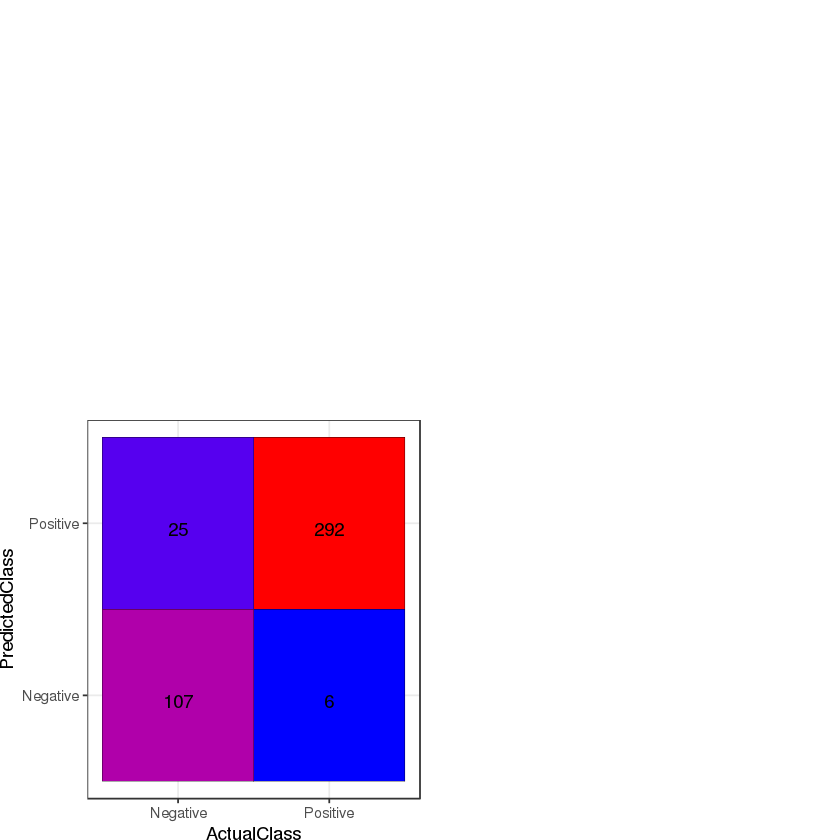

In [18]:
## lets see how our models' confusion matrix look like

# get the confusion marix
svm_preds_cm <- as.data.frame(svm_preds_1$ctable)

# print it

one <- "Positive"
zero <- "Negative"

ActualClass <- factor(c(one, one, zero, zero))
PredictedClass <- factor(c(one, zero, one, zero))

# get the parts of CM
TP <- svm_preds_cm[[1]][[1]]
TN <- svm_preds_cm[[2]][[2]]
FN <- svm_preds_cm[[2]][[1]]
FP <- svm_preds_cm[[1]][[2]]
ConfusionMatrix <- c(TP, FP, FN, TN)

# create
svm_preds_cm_df <- data.frame(ActualClass, PredictedClass,ConfusionMatrix )

# plot
library(ggplot2)

g <- ggplot(data =  svm_preds_cm_df, mapping = aes(x = ActualClass, y = PredictedClass)) +
     geom_tile(aes(fill=ConfusionMatrix), colour = "black") +
     geom_text(aes(label = sprintf("%1.0f", ConfusionMatrix)), vjust = 1) +
     scale_fill_gradient(low = "blue", high = "red") +
     theme_bw() +
     theme(legend.position="none",
           plot.margin=unit(c(0,0,0,0), "cm"))
 
library(cowplot)
ggdraw()+draw_plot(g,width=0.5,height = 0.5)
           

#### Scores

We can also see the predicted scores. The higher the score, the higher the margin and the better, or more confident we are of the prediction.


In [19]:

head(svm_preds_1$scores)


class:1,class:2
1.8097469,-1.8097469
1.6077980,-1.6077980
1.6757843,-1.6757843
-0.1936054,0.1936054
1.1191495,-1.1191495
1.5759885,-1.5759885


 ### 4.4. Summary of classification using SVM
 
 
 We saw:
 
  * How to formulate the problem in terms of classification task.

  * Use R4ML to train the scalable SVM model.
 
  * Predict the scores on the held-out data.
 
  * Analyse the prediction using various perspectives.
 

## 5. Model-Tuning via Cross-Validation



### 5.1. Cross-Validation Overview

Many models have important parameters which cannot be directly estimated from the data. For example, in the SVM classification problem, to avoid overfitting, it should be adjusted using the tuning parameter lambda. The question is: what should the value be?

There are different approaches to searching for the best parameters. A general approach that can be applied to almost any model is to define a set of candidate values, generate reliable estimates of model utility across the candidate values, then choose the optimal settings. A flowchart of this process is shown in the following figure:


 * First we select the set of parameters that define our model.
 * For each parameter, run the k fold validation and record it's performance.
 * Then pick the model which gives the best accuracy.

The following figure illustrates the idea:


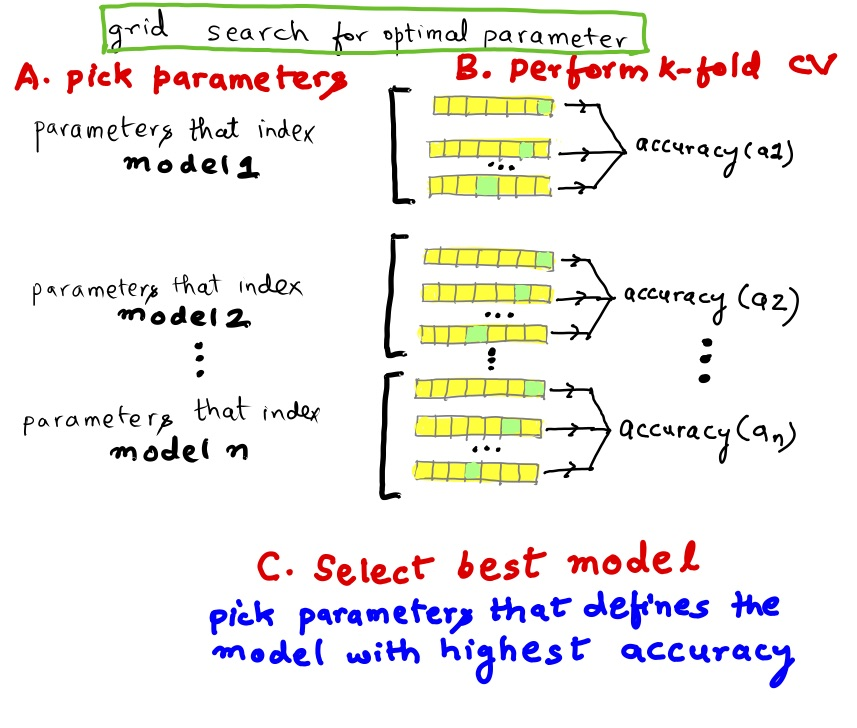


Once we determine the model, lets evaluate it with respect to the grid search. While the k-fold cross-validation could be applied here, we will use the 2-fold cross-validation.


### 5.2. CV for SVM model

Here is the R code to achieve this.
 
 

In [20]:
lambdas <- c(0, 0.1, 0.4, 0.7, 1, 2, 3, 4, 5)
svm_models <- list()
svm_preds <- list()
cat("\n Running the Grid Search for finding best parameter\n")
for (i in 1:length(lambdas)) {

  lambda <- lambdas[i]

  cat(paste0("\n Creating model for the parameter ", lambda, "\n"))  
  svm_model_i <- suppressWarnings(r4ml.svm(Delayed ~ ., data = svm_train_1,   lambda=lambda))

  cat(paste0("\n Running model performance [via prediction] for the parameter ", lambda, "\n"))  
  svm_preds_i <- suppressWarnings(predict(svm_model_i, svm_test_1))

  svm_models[[length(svm_models) + 1]] <- svm_model_i

  svm_preds[[length(svm_preds) + 1]] <- svm_preds_i


}



 Running the Grid Search for finding best parameter

 Creating model for the parameter 0

 Running model performance [via prediction] for the parameter 0


INFO[predict.r4ml.svm]: Predicting labels using given SVM model/gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/R4ML/scratch_workspace/r4ml.svm/c7f4b770-4933-436e-9e2e-2ab921c72847/on data
INFO[r4ml.ml.checkModelFeaturesMatchData]: Ensuring the consistency between model and data features
INFO[packagePredictSvmOutput]: Packaging output of svm predict



 Creating model for the parameter 0.1

 Running model performance [via prediction] for the parameter 0.1


INFO[predict.r4ml.svm]: Predicting labels using given SVM model/gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/R4ML/scratch_workspace/r4ml.svm/a7a51c2e-b960-4417-8505-ba08cb3803cf/on data
INFO[r4ml.ml.checkModelFeaturesMatchData]: Ensuring the consistency between model and data features
INFO[packagePredictSvmOutput]: Packaging output of svm predict



 Creating model for the parameter 0.4

 Running model performance [via prediction] for the parameter 0.4


INFO[predict.r4ml.svm]: Predicting labels using given SVM model/gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/R4ML/scratch_workspace/r4ml.svm/3ac1ec55-f9fa-4360-bfdf-1b242b6b93d2/on data
INFO[r4ml.ml.checkModelFeaturesMatchData]: Ensuring the consistency between model and data features
INFO[packagePredictSvmOutput]: Packaging output of svm predict



 Creating model for the parameter 0.7

 Running model performance [via prediction] for the parameter 0.7


INFO[predict.r4ml.svm]: Predicting labels using given SVM model/gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/R4ML/scratch_workspace/r4ml.svm/8b5827e7-d733-4406-8155-38ac94a625df/on data
INFO[r4ml.ml.checkModelFeaturesMatchData]: Ensuring the consistency between model and data features
INFO[packagePredictSvmOutput]: Packaging output of svm predict



 Creating model for the parameter 1

 Running model performance [via prediction] for the parameter 1


INFO[predict.r4ml.svm]: Predicting labels using given SVM model/gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/R4ML/scratch_workspace/r4ml.svm/1ea61e7c-0366-4e86-be66-95c103f5062e/on data
INFO[r4ml.ml.checkModelFeaturesMatchData]: Ensuring the consistency between model and data features
INFO[packagePredictSvmOutput]: Packaging output of svm predict



 Creating model for the parameter 2

 Running model performance [via prediction] for the parameter 2


INFO[predict.r4ml.svm]: Predicting labels using given SVM model/gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/R4ML/scratch_workspace/r4ml.svm/ba2cd293-41f8-4501-be46-3099802ad5c5/on data
INFO[r4ml.ml.checkModelFeaturesMatchData]: Ensuring the consistency between model and data features
INFO[packagePredictSvmOutput]: Packaging output of svm predict



 Creating model for the parameter 3

 Running model performance [via prediction] for the parameter 3


INFO[predict.r4ml.svm]: Predicting labels using given SVM model/gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/R4ML/scratch_workspace/r4ml.svm/7ccc2957-048f-42f1-b429-7cf0d8aaec36/on data
INFO[r4ml.ml.checkModelFeaturesMatchData]: Ensuring the consistency between model and data features
INFO[packagePredictSvmOutput]: Packaging output of svm predict



 Creating model for the parameter 4

 Running model performance [via prediction] for the parameter 4


INFO[predict.r4ml.svm]: Predicting labels using given SVM model/gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/R4ML/scratch_workspace/r4ml.svm/552e20a6-355c-49b6-92a0-7e7ea5383eb7/on data
INFO[r4ml.ml.checkModelFeaturesMatchData]: Ensuring the consistency between model and data features
INFO[packagePredictSvmOutput]: Packaging output of svm predict



 Creating model for the parameter 5

 Running model performance [via prediction] for the parameter 5


INFO[predict.r4ml.svm]: Predicting labels using given SVM model/gpfs/fs01/user/sa28-9716de71e3ac0f-9ac12ed2939a/R4ML/scratch_workspace/r4ml.svm/748d4852-57f1-474f-b8b4-b97bf73e09b2/on data
INFO[r4ml.ml.checkModelFeaturesMatchData]: Ensuring the consistency between model and data features
INFO[packagePredictSvmOutput]: Packaging output of svm predict


##### Best Model

Let's look at the best lambda (the tuning parameter).

In [21]:

#now check which one gives us the best accuracy
svm_accs <- sapply(svm_preds, function(p) {p$accuracy})
best_fit_idx <- which(svm_accs == max(svm_accs))
lambdas[best_fit_idx]


[1] 0

##### Visualizing the performance of all the models

Let's also plot other model's relative performance in terms of accuracy


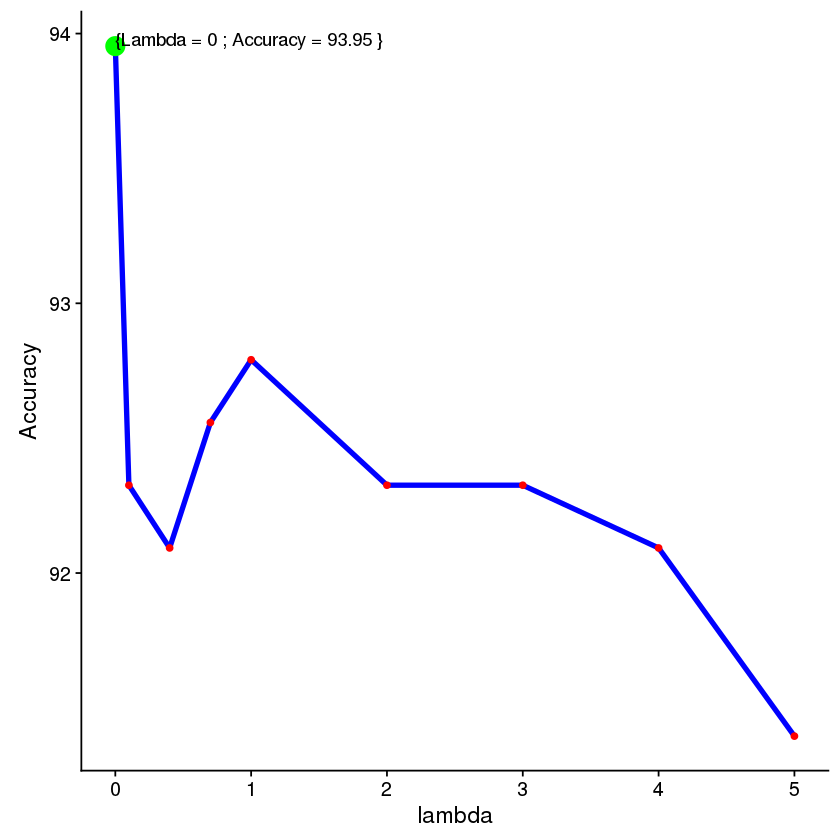

In [61]:

acc_df <- data.frame( lambda=lambdas, Accuracy = svm_accs)
acc_df_best <- acc_df[best_fit_idx,]
best_text <- paste0("{Lambda = ", lambdas[best_fit_idx], " ; Accuracy = ", round(acc_df_best$Accuracy, digits=2), " }")
acc_g = ggplot(data=acc_df, aes(x=lambda, y=Accuracy, group=1)) +
  geom_line(color="blue", size = 1.5) +
  geom_point(color="red") + 
  geom_point(data=acc_df_best, aes(x=lambda, y=Accuracy), colour="green", size=5) + 
  geom_text(data=acc_df_best, label=best_text, vjust=0, hjust=0)
acc_g

# to limit the plot
#ggdraw()+draw_plot(acc_g,width=0.5,height = 0.5)


## 6. Summary and next steps ...

In this section, we saw: 

- The end-to-end data processing pipeline for scalable machine learning flow using R4ML, a hybrid tool on the top of Apache SparkR and Apache SystemML.

- How we can build a classification Support Vector Model for predicting the arrival delay of an airline. 

- In the end we used the classic model tuning to select the best set of parameters.
